<h1 align="center"> SDF Tutorien als StoneSoup Notebook </h1>
<h3 align="center"> Aufgaben mit dem Framework programmieren </h3>

In [1]:
from stonesoup.base import Property
%matplotlib qt

from datetime import timedelta
from datetime import datetime

import numpy as np

<h2 align="center"> Erstellen der Ausgabe </h2>

In [2]:
velocity = 300.0
acceleration = 9.0
omega = acceleration / ( 2 * velocity)
A = (velocity**2) / acceleration

In [3]:
# Figure to plot truth (and future data)
from matplotlib import pyplot as plt
figure = plt.figure(figsize=(16, 9))
ax = figure.add_subplot(1, 1, 1)
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")

from stonesoup.types.groundtruth import GroundTruthPath, GroundTruthState

truth = GroundTruthPath()
start_time = datetime.now()

data = np.linspace(0, (2 * np.pi )/ omega, 100, endpoint = True)

for t in data:
    x = A * np.sin(omega * t)
    y = A * np.sin(2 * omega * t)
    truth.append(GroundTruthState(np.array([[x], [y]]), timestamp=start_time+timedelta(seconds=t)))

ax.plot([state.state_vector[0, 0] for state in truth], 
        [state.state_vector[1, 0] for state in truth], 
        linestyle="--", color="grey")

Groundtruth erstellt, jetzt Messungen generieren.

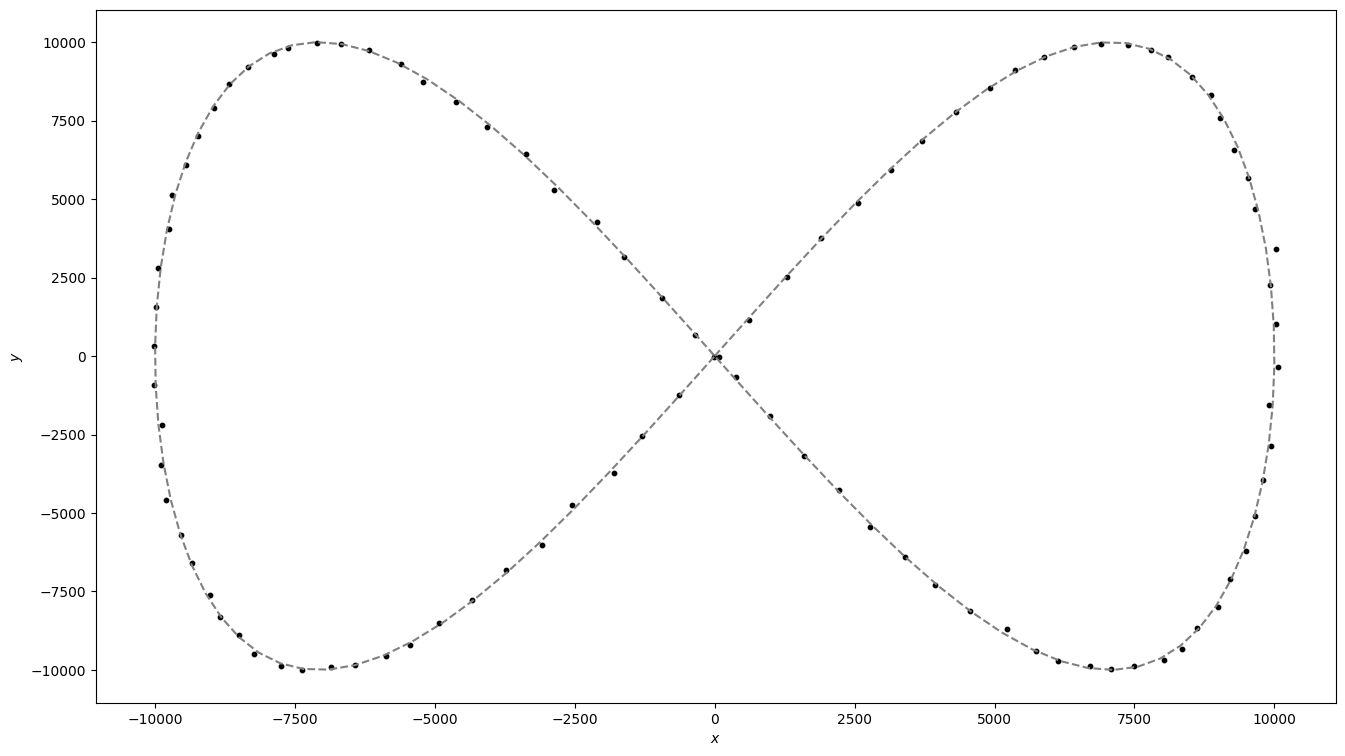

In [4]:
from stonesoup.types.detection import Detection

measurements = []
for state in truth:
    xOffset = 50 * np.random.normal(0, 1, 1)
    yOffset = 50 * np.random.normal(0, 1, 1)
    x = state.state_vector[0, 0]
    y = state.state_vector[1, 0]
    measurements.append(Detection(
        np.array([[x] + xOffset, [y] + yOffset]), timestamp=state.timestamp))
    
# Plot the result
ax.scatter([state.state_vector[0, 0] for state in measurements], 
           [state.state_vector[1, 0] for state in measurements], 
           color='black', s = 10)
figure

Transitionsmodell erstellen
----------------------------
Transitionsmatrix $F$ und Prozessrauschen $Q$ erstellen

In [5]:
from stonesoup.models.transition.linear import CombinedLinearGaussianTransitionModel, ConstantVelocity
# from tutorienklassen import PCWAModel

# transition_model = CombinedLinearGaussianTransitionModel((PCWAModel(), PCWAModel()))
transition_model = CombinedLinearGaussianTransitionModel((ConstantVelocity(0.5), ConstantVelocity(0.5)))


In [6]:
transition_model.matrix(time_interval=timedelta(seconds=1))

array([[1., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 1.],
       [0., 0., 0., 1.]])

In [7]:
transition_model.covar(time_interval=timedelta(seconds=1))

array([[0.16666667, 0.25      , 0.        , 0.        ],
       [0.25      , 0.5       , 0.        , 0.        ],
       [0.        , 0.        , 0.16666667, 0.25      ],
       [0.        , 0.        , 0.25      , 0.5       ]])

Predictor-Komponente programmieren um $x_{k|k-1}$ zu bekommen

In [8]:
from stonesoup.predictor.kalman import KalmanPredictor
from tutorienklassen import SdfKalmanPredictor
predictor_Kalman = KalmanPredictor(transition_model)
predictor = SdfKalmanPredictor(transition_model)

Als nächstes Messmodell erstellen

In [9]:
from stonesoup.models.measurement.linear import LinearGaussian
from tutorienklassen import SDFMessmodell
measurement_model = SDFMessmodell(
    4, # Number of state dimensions (position and velocity in 2D)
    (0, 2), # Mapping measurement vector index to state index
    np.array([[0.75, 0],  # Covariance matrix for Gaussian PDF
              [0, 0.75]])
    )
measurement_model_Kalman = SDFMessmodell(4, (0, 2), np.array([[0.75, 0], [0, 0.75]]))

Damit erhalten wir die Messmatrix $H$ und das Messrauschen $R$.

In [10]:
measurement_model.matrix()


array([[1, 0, 0, 0],
       [0, 0, 1, 0]])

In [11]:
measurement_model.covar()

array([[0.75, 0.  ],
       [0.  , 0.75]])

Filter bauen, der anhand einer Messung $x_{k|k}$ berechnet

In [12]:
from stonesoup.updater.kalman import KalmanUpdater
from tutorienklassen import SDFUpdater
updater = SDFUpdater(measurement_model)
updaterKalman = KalmanUpdater(measurement_model_Kalman)

Kalman-Filter ausführen
-----------------------
Alle Komponenten sind kreiert, jetzt Startzustand wählen

In [13]:
from stonesoup.types.state import GaussianState
prior = GaussianState([[0], [1], [0], [1]], np.diag([10.5, 0.5, 10.5, 0.5]), timestamp=start_time)
prior_Kalman = GaussianState([[0], [1], [0], [1]], np.diag([10.5, 0.5, 10.5, 0.5]), timestamp=start_time)

Alle Messungen durchgehen, prädizieren und updaten.
Komponenten zum Test/Vergleich doppelt


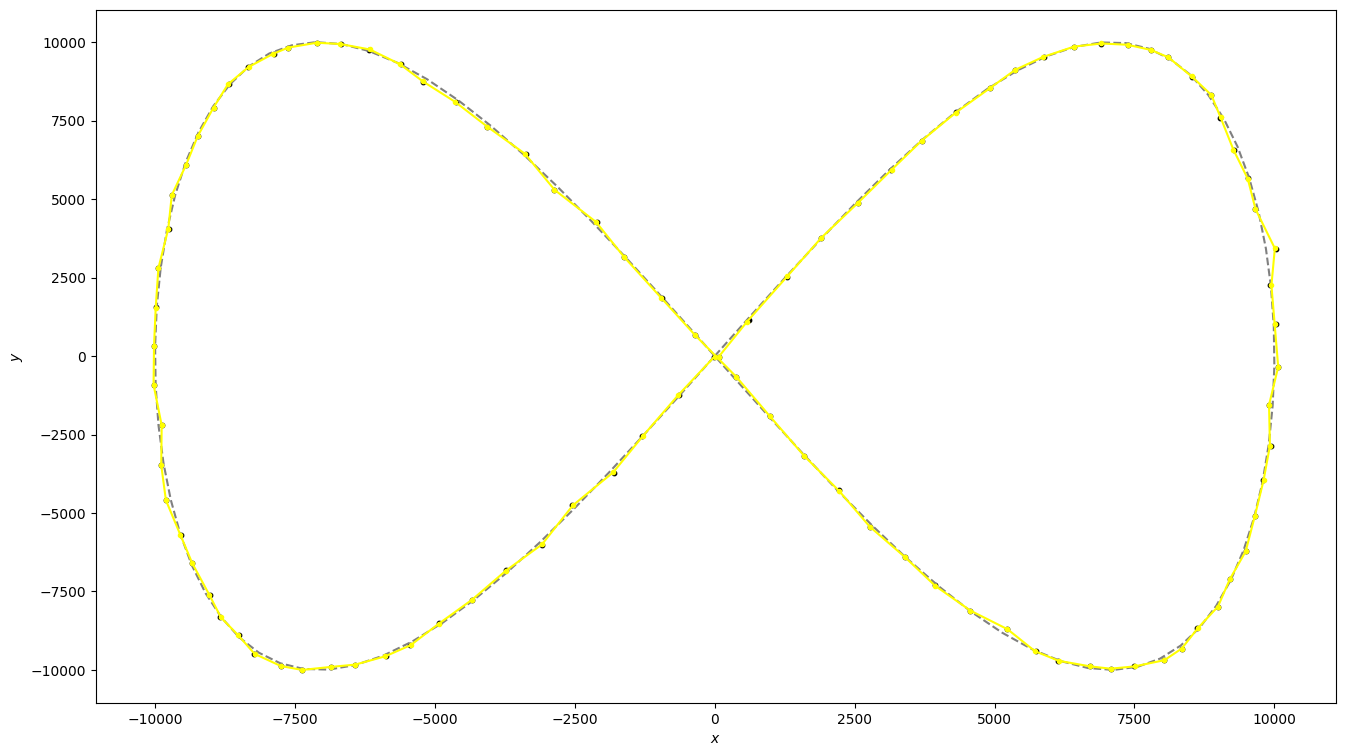

In [14]:
from stonesoup.types.hypothesis import SingleHypothesis
from stonesoup.types.track import Track

track = Track()
track_Kalman = Track()
for measurement in measurements:
    prediction = predictor.predict(prior, timestamp=measurement.timestamp)
    prediction_Kalman = predictor_Kalman.predict(prior, timestamp=measurement.timestamp)
    
    hypothesis = SingleHypothesis(prediction, measurement) # Used to group a prediction and measurement together
    hypothesis_Kalman = SingleHypothesis(prediction_Kalman, measurement)
    
    post = updater.update(hypothesis, measurement_model)
    post_Kalman = updaterKalman.update(hypothesis_Kalman)
    
    track.append(post)
    track_Kalman.append(post_Kalman)
    
    prior = track[-1]
    prior_Kalman = track_Kalman[-1]

# Plot the resulting track
ax.plot([state.state_vector[0, 0] for state in track], 
        [state.state_vector[2, 0] for state in track],
        marker=".", color = "yellow")
figure

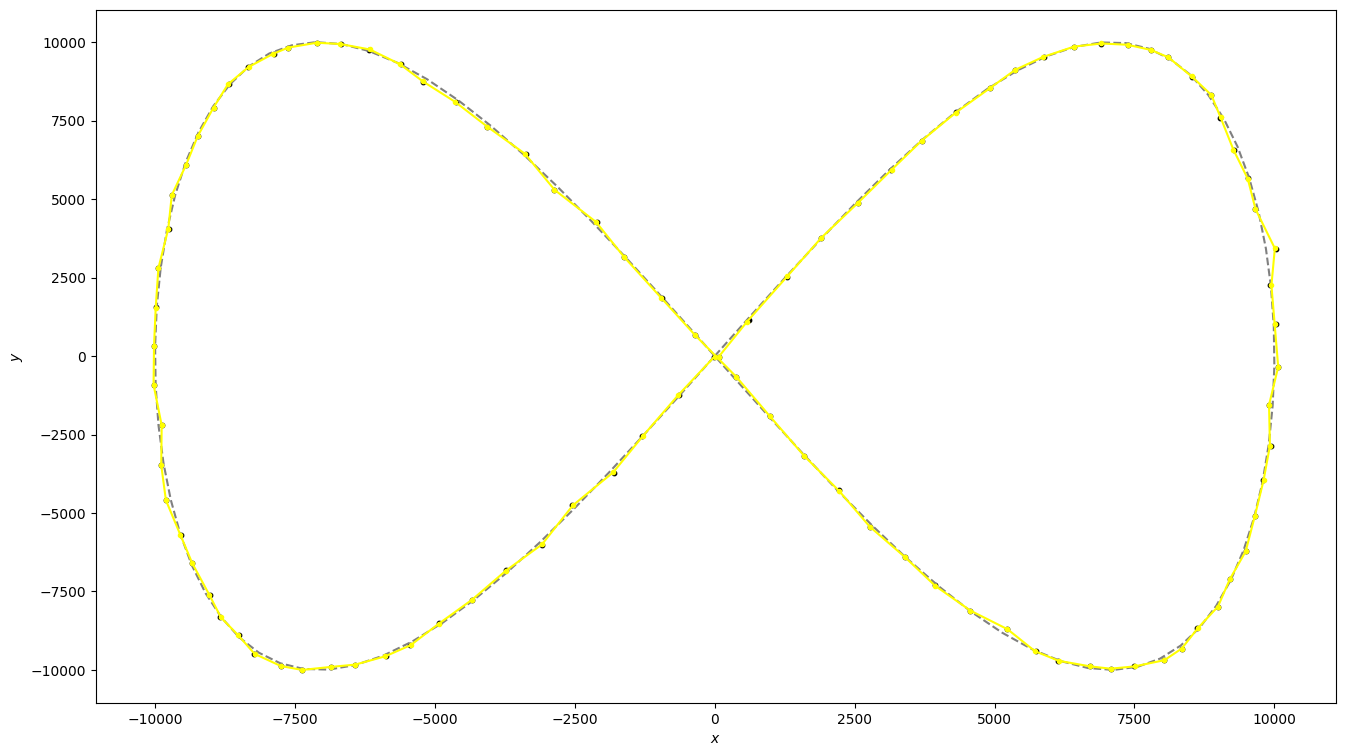

In [15]:
from matplotlib.patches import Ellipse
for state in track:
    w, v = np.linalg.eig(measurement_model.matrix()@state.covar@measurement_model.matrix().T)
    max_ind = np.argmax(v[0, :])
    orient = np.arctan2(v[max_ind, 1], v[max_ind, 0])
    ellipse = Ellipse(xy=state.state_vector[(0,2), 0],
                      width=np.sqrt(w[0])*50, height=np.sqrt(w[1])*50,
                      angle=np.rad2deg(orient),
                      alpha=0.2)
    ax.add_artist(ellipse)
figure